In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df =pd.read_csv("/content/diabetes.csv")

In [ ]:
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
corr_matrix = df.corr()

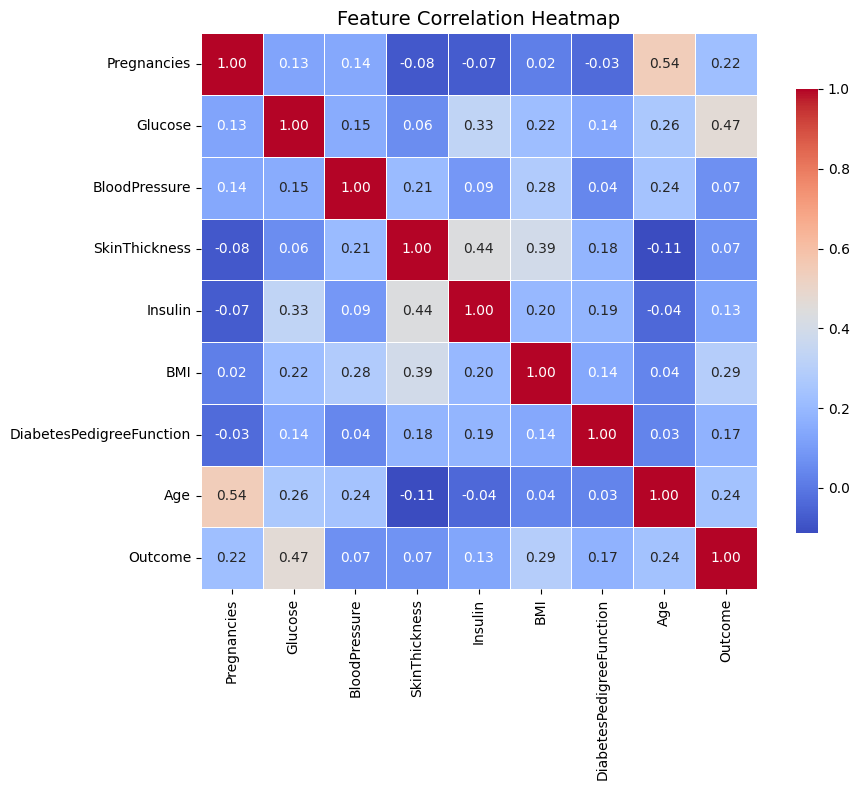

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_matrix,
    annot=True,
     fmt=".2f",
    cmap="coolwarm",       # or "viridis", "Blues", etc.
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

Model training prep

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
X=df.drop('Outcome',axis=1)
Y=df['Outcome']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X_scaled,Y,test_size=0.2,random_state=42)

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train,Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred=model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test,y_pred))
print("F1 Score:", f1_score(Y_test,y_pred))
print("\nClassification Report:\n", classification_report(Y_test,y_pred))

Accuracy: 0.7272727272727273
F1 Score: 0.6181818181818182

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        99
           1       0.62      0.62      0.62        55

    accuracy                           0.73       154
   macro avg       0.70      0.70      0.70       154
weighted avg       0.73      0.73      0.73       154



In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(RandomForestClassifier(), X_scaled, Y, cv=5, scoring='f1')
print("CV F1 Scores:", cv_scores)
print("Mean F1 Score:", cv_scores.mean())


CV F1 Scores: [0.64150943 0.61111111 0.54761905 0.70103093 0.59574468]
Mean F1 Score: 0.6194030402757076


feature Engineering

In [ ]:
df['BMI_Age'] = df['BMI'] * df['Age']
df['Glucose_Insulin_Ratio'] = df['Glucose'] / (df['Insulin'] + 1)  # to avoid division by zero


In [ ]:
# Count each class
print(df['Outcome'].value_counts())


Outcome
0    500
1    268
Name: count, dtype: int64


In [ ]:
print(Y_train.value_counts())

Outcome
0    401
1    213
Name: count, dtype: int64


Since dataset has imbalanced output -> performing smote - Synthetic Minority Oversampling Technique

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

sm= SMOTE(random_state = 42)
X_resampled, Y_resampled = sm.fit_resample(X_train,Y_train)

print("Before SMOTE:", Y_train.value_counts())
print("After SMOTE:", Y_resampled.value_counts())

Before SMOTE: Outcome
0    401
1    213
Name: count, dtype: int64
After SMOTE: Outcome
0    401
1    401
Name: count, dtype: int64


In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled,Y_resampled)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test,y_pred))
print("F1 Score:", f1_score(Y_test,y_pred))
print("\nClassification Report:\n", classification_report(Y_test,y_pred))

Accuracy: 0.7597402597402597
F1 Score: 0.6942148760330579

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.76      0.80        99
           1       0.64      0.76      0.69        55

    accuracy                           0.76       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.78      0.76      0.76       154



okay lets try XGBoost since its good in tabular structured data

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xg_model = XGBClassifier(use_label_encoder=False,eval_metrics='logloss',random_state=42)
xg_model.fit(X_resampled,Y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_xg = xg_model.predict(X_test)
print("Accuracy:", accuracy_score(Y_test,y_pred_xg))
print("F1 Score:", f1_score(Y_test,y_pred_xg))
print("\nClassification Report:\n", classification_report(Y_test,y_pred_xg))

Accuracy: 0.6948051948051948
F1 Score: 0.6178861788617886

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.70      0.75        99
           1       0.56      0.69      0.62        55

    accuracy                           0.69       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.72      0.69      0.70       154



Hyper tuning the Random Forest Model to improve

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Create the base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Fit to the resampled training data
grid_search.fit(X_resampled, Y_resampled)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate on test data
y_pred = best_rf.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print(classification_report(Y_test, y_pred))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.84      0.75      0.79        99
           1       0.62      0.75      0.68        55

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.75      0.75       154



In [ ]:
print("Accuracy:", accuracy_score(Y_test,y_pred))
print("F1 Score:", f1_score(Y_test,y_pred))

Accuracy: 0.7467532467532467
F1 Score: 0.6776859504132231
